# Convolutional Variational Autoencoder Implementation for Reconstruction of CartoonFaces dataset

In this notebook we train a Variational Autoencoder (VAE) on the CartoonFaces dataset (https://www.kaggle.com/datasets/brendanartley/cartoon-faces-googles-cartoon-set). The VAE is a type of autoencoder probabilistic. So instead of leatting our neural network learn an arbitrary function, we are learning the parameters of a probability distribution modeling our data.

### Import the dataset from Kaggle

In [1]:
import kaggle

In [2]:
!kaggle datasets download -d brendanartley/cartoon-faces-googles-cartoon-set

cartoon-faces-googles-cartoon-set.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
import os
from glob import glob
 

DATA_FOLDER = './cartoonset100k_jpg/cartoonset100k_jpg/'


#Unzip the dataset downloaded from kaggle
from zipfile import ZipFile
with ZipFile('cartoon-faces-googles-cartoon-set.zip', 'r') as zipObj:
   # Extract all the contents of zip file in the data directory
   zipObj.extractall('./cartoonset100k_jpg/')

### Setup

In [4]:
import numpy as np

import os
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.utils import plot_model

In [5]:
filenames = np.array(glob(os.path.join(DATA_FOLDER, '*/*.jpg')))
NUM_IMAGES = len(filenames)
print("Total number of images : " + str(NUM_IMAGES))

Total number of images : 100000


### Generate batch

Since using the whole dataset would be very computational expensive we are only using a batch of 512 images.

In [49]:
INPUT_DIM = (64,64,3) # Image dimension
BATCH_SIZE = 128
Z_DIM = 128 # Dimension of the latent vector (z)

data_flow = ImageDataGenerator(rescale=1./255).flow_from_directory(DATA_FOLDER, 
                                                                   target_size = INPUT_DIM[:2],
                                                                   batch_size = BATCH_SIZE,
                                                                   shuffle = True,
                                                                   class_mode = 'input',
                                                                   subset = 'training'
                                                                   )

Found 100000 images belonging to 10 classes.


### Define the architecture of our encoder and decoder networks 

In this VAE example, we use two small ConvNets for the encoder and decoder networks. In the literature, these networks are also referred to as inference/recognition and generative models respectively.  Let $x$ and $z$ denote the observation and latent variable respectively in the following descriptions.

### Encoder network
This defines the approximate posterior distribution $q(z|x)$, which takes as input an observation $x$ and outputs a set of parameters for specifying the conditional distribution of the latent representation $z$. 


### Decoder network 
This defines the conditional distribution of the observation $p(x|z)$, which takes a latent sample $z$ as input and outputs the parameters for a conditional distribution of the observation $x$. Model the latent distribution prior $p(z)$ as a unit Gaussian.


### Reparameterization trick
To generate a sample $z$ for the decoder during training, you can sample from the latent distribution defined by the parameters outputted by the encoder, given an input observation $x$.
However, this sampling operation creates a bottleneck because backpropagation cannot flow through a random node.

To address this, use a reparameterization trick.
In our example, you approximate $z$ using the decoder parameters and another parameter $\epsilon$ as follows:

$$z = \mu + \sigma \odot \epsilon$$

where $\mu$ and $\sigma$ represent the mean and standard deviation of a Gaussian distribution respectively. They can be derived from the decoder output. The $\epsilon$ can be thought of as a random noise used to maintain stochasticity of $z$. Generate $\epsilon$ from a standard normal distribution.

The latent variable $z$ is now generated by a function of $\mu$, $\sigma$ and $\epsilon$, which would enable the model to backpropagate gradients in the encoder through $\mu$ and $\sigma$ respectively, while maintaining stochasticity through $\epsilon$.

### Network architecture
For the encoder network, use four convolutional layers followed by a fully-connected layer. In the decoder network, mirror this architecture by using a fully-connected layer followed by five convolution transpose layers (a.k.a. deconvolutional layers in some contexts). 

### Create a sampling layer

In [50]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

### Build the encoder

In [51]:
latent_dim = Z_DIM

encoder_inputs = keras.Input(shape=INPUT_DIM)


x = layers.Conv2D(32, 3, strides=1, padding="same")(encoder_inputs)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2D(32, 3, strides=1, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2D(64, 3, strides=1, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2D(256, 3, strides=2, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Flatten()(x)

x = layers.Dropout(0.40)(x)

x = layers.Dense(2048)(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="Encoder")
encoder.summary()

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_21 (Conv2D)             (None, 64, 64, 32)   896         ['input_7[0][0]']                
                                                                                                  
 leaky_re_lu_51 (LeakyReLU)     (None, 64, 64, 32)   0           ['conv2d_21[0][0]']              
                                                                                                  
 conv2d_22 (Conv2D)             (None, 64, 64, 32)   9248        ['leaky_re_lu_51[0][0]']         
                                                                                            

### Build the decoder

In [52]:
latent_inputs = keras.Input(shape=(latent_dim,))

x = layers.Dense(2048)(latent_inputs)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Dense(4*4*256)(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Reshape((4,4,256))(x)

x = layers.Conv2DTranspose(256, 3, strides=2, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(128, 3, strides=2, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(64, 3, strides=2, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(64, 3, strides=1, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(32, 3, strides=2, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(32, 3, strides=1, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(32, 3, strides=1, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)


decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="Decoder")
decoder.summary()

Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_10 (Dense)            (None, 2048)              264192    
                                                                 
 leaky_re_lu_59 (LeakyReLU)  (None, 2048)              0         
                                                                 
 dense_11 (Dense)            (None, 4096)              8392704   
                                                                 
 leaky_re_lu_60 (LeakyReLU)  (None, 4096)              0         
                                                                 
 reshape_3 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_24 (Conv2D  (None, 8, 8, 256)        5900

### Define the VAE as a `Model` with a custom `train_step`

In [53]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss           
        
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

### Train the VAE

In [54]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(1e-3))
history = vae.fit(data_flow[0][0], epochs=500, batch_size=64)

Epoch 1/500
2/2 [==============================] - 2s 50ms/step - loss: 2834.6736 - reconstruction_loss: 2832.1646 - kl_loss: 0.0166
Epoch 2/500
2/2 [==============================] - 0s 45ms/step - loss: 2694.9566 - reconstruction_loss: 2656.3633 - kl_loss: 0.5134
Epoch 3/500
2/2 [==============================] - 0s 50ms/step - loss: 3527.4243 - reconstruction_loss: 3939.9446 - kl_loss: 387.8587
Epoch 4/500
2/2 [==============================] - 0s 50ms/step - loss: 1714.3580 - reconstruction_loss: 1747.9270 - kl_loss: 22.0086
Epoch 5/500
2/2 [==============================] - 0s 48ms/step - loss: 2207.9648 - reconstruction_loss: 2224.0815 - kl_loss: 0.2444
Epoch 6/500
2/2 [==============================] - 0s 46ms/step - loss: 2288.0517 - reconstruction_loss: 2284.2295 - kl_loss: 0.0317
Epoch 7/500
2/2 [==============================] - 0s 52ms/step - loss: 2168.1282 - reconstruction_loss: 2148.9536 - kl_loss: 0.0347
Epoch 8/500
2/2 [==============================] - 0s 43ms/step - 

2/2 [==============================] - 0s 44ms/step - loss: 825.5616 - reconstruction_loss: 821.3385 - kl_loss: 2.8917
Epoch 63/500
2/2 [==============================] - 0s 50ms/step - loss: 823.9899 - reconstruction_loss: 812.9142 - kl_loss: 3.4151
Epoch 64/500
2/2 [==============================] - 0s 48ms/step - loss: 809.7168 - reconstruction_loss: 811.1845 - kl_loss: 2.8901
Epoch 65/500
2/2 [==============================] - 0s 48ms/step - loss: 811.9454 - reconstruction_loss: 806.8741 - kl_loss: 3.7062
Epoch 66/500
2/2 [==============================] - 0s 47ms/step - loss: 805.2767 - reconstruction_loss: 802.2184 - kl_loss: 4.4502
Epoch 67/500
2/2 [==============================] - 0s 60ms/step - loss: 810.7267 - reconstruction_loss: 799.9578 - kl_loss: 5.2678
Epoch 68/500
2/2 [==============================] - 0s 50ms/step - loss: 801.1339 - reconstruction_loss: 795.6078 - kl_loss: 4.9761
Epoch 69/500
2/2 [==============================] - 0s 50ms/step - loss: 793.1419 - recon

2/2 [==============================] - 0s 46ms/step - loss: 726.5429 - reconstruction_loss: 715.9483 - kl_loss: 13.2819
Epoch 124/500
2/2 [==============================] - 0s 46ms/step - loss: 725.8783 - reconstruction_loss: 718.6936 - kl_loss: 11.2882
Epoch 125/500
2/2 [==============================] - 0s 44ms/step - loss: 722.6823 - reconstruction_loss: 715.3854 - kl_loss: 11.0816
Epoch 126/500
2/2 [==============================] - 0s 51ms/step - loss: 720.5098 - reconstruction_loss: 710.8395 - kl_loss: 14.0133
Epoch 127/500
2/2 [==============================] - 0s 49ms/step - loss: 719.2346 - reconstruction_loss: 709.7170 - kl_loss: 11.7423
Epoch 128/500
2/2 [==============================] - 0s 43ms/step - loss: 722.8365 - reconstruction_loss: 707.5328 - kl_loss: 12.5657
Epoch 129/500
2/2 [==============================] - 0s 50ms/step - loss: 712.8380 - reconstruction_loss: 703.3074 - kl_loss: 14.4738
Epoch 130/500
2/2 [==============================] - 0s 46ms/step - loss: 71

2/2 [==============================] - 0s 52ms/step - loss: 666.6705 - reconstruction_loss: 646.2451 - kl_loss: 18.2038
Epoch 185/500
2/2 [==============================] - 0s 54ms/step - loss: 661.8665 - reconstruction_loss: 641.3762 - kl_loss: 18.8433
Epoch 186/500
2/2 [==============================] - 0s 48ms/step - loss: 656.4871 - reconstruction_loss: 638.6454 - kl_loss: 18.6761
Epoch 187/500
2/2 [==============================] - 0s 49ms/step - loss: 664.4918 - reconstruction_loss: 641.0413 - kl_loss: 18.6016
Epoch 188/500
2/2 [==============================] - 0s 46ms/step - loss: 653.5246 - reconstruction_loss: 639.4149 - kl_loss: 17.1079
Epoch 189/500
2/2 [==============================] - 0s 49ms/step - loss: 657.8956 - reconstruction_loss: 638.5113 - kl_loss: 17.3016
Epoch 190/500
2/2 [==============================] - 0s 46ms/step - loss: 647.3236 - reconstruction_loss: 637.5823 - kl_loss: 18.4552
Epoch 191/500
2/2 [==============================] - 0s 51ms/step - loss: 65

2/2 [==============================] - 0s 55ms/step - loss: 628.1160 - reconstruction_loss: 614.4634 - kl_loss: 16.0073
Epoch 246/500
2/2 [==============================] - 0s 50ms/step - loss: 630.5371 - reconstruction_loss: 609.3445 - kl_loss: 19.3851
Epoch 247/500
2/2 [==============================] - 0s 46ms/step - loss: 631.0737 - reconstruction_loss: 608.9850 - kl_loss: 19.0997
Epoch 248/500
2/2 [==============================] - 0s 55ms/step - loss: 627.4950 - reconstruction_loss: 609.2406 - kl_loss: 17.4131
Epoch 249/500
2/2 [==============================] - 0s 55ms/step - loss: 625.5998 - reconstruction_loss: 608.6484 - kl_loss: 18.7618
Epoch 250/500
2/2 [==============================] - 0s 50ms/step - loss: 636.8817 - reconstruction_loss: 607.4636 - kl_loss: 20.1723
Epoch 251/500
2/2 [==============================] - 0s 46ms/step - loss: 623.8925 - reconstruction_loss: 610.1758 - kl_loss: 17.7840
Epoch 252/500
2/2 [==============================] - 0s 50ms/step - loss: 61

2/2 [==============================] - 0s 51ms/step - loss: 606.1196 - reconstruction_loss: 591.6974 - kl_loss: 18.0509
Epoch 307/500
2/2 [==============================] - 0s 49ms/step - loss: 608.2954 - reconstruction_loss: 592.3034 - kl_loss: 17.5185
Epoch 308/500
2/2 [==============================] - 0s 50ms/step - loss: 603.1377 - reconstruction_loss: 590.0255 - kl_loss: 17.8369
Epoch 309/500
2/2 [==============================] - 0s 51ms/step - loss: 609.2969 - reconstruction_loss: 589.4929 - kl_loss: 17.6298
Epoch 310/500
2/2 [==============================] - 0s 52ms/step - loss: 605.2123 - reconstruction_loss: 589.0671 - kl_loss: 16.6461
Epoch 311/500
2/2 [==============================] - 0s 56ms/step - loss: 606.6076 - reconstruction_loss: 586.2067 - kl_loss: 18.3246
Epoch 312/500
2/2 [==============================] - 0s 61ms/step - loss: 606.6427 - reconstruction_loss: 586.4147 - kl_loss: 17.9173
Epoch 313/500
2/2 [==============================] - 0s 48ms/step - loss: 59

2/2 [==============================] - 0s 56ms/step - loss: 585.0001 - reconstruction_loss: 566.8518 - kl_loss: 17.7284
Epoch 368/500
2/2 [==============================] - 0s 50ms/step - loss: 582.7360 - reconstruction_loss: 565.3009 - kl_loss: 18.1565
Epoch 369/500
2/2 [==============================] - 0s 54ms/step - loss: 586.1445 - reconstruction_loss: 566.7310 - kl_loss: 17.7137
Epoch 370/500
2/2 [==============================] - 0s 51ms/step - loss: 583.6091 - reconstruction_loss: 565.4758 - kl_loss: 17.7111
Epoch 371/500
2/2 [==============================] - 0s 50ms/step - loss: 580.8530 - reconstruction_loss: 564.7460 - kl_loss: 17.8702
Epoch 372/500
2/2 [==============================] - 0s 48ms/step - loss: 583.9757 - reconstruction_loss: 565.0823 - kl_loss: 18.0316
Epoch 373/500
2/2 [==============================] - 0s 49ms/step - loss: 583.1600 - reconstruction_loss: 563.5735 - kl_loss: 18.2763
Epoch 374/500
2/2 [==============================] - 0s 48ms/step - loss: 58

2/2 [==============================] - 0s 50ms/step - loss: 575.0249 - reconstruction_loss: 553.4111 - kl_loss: 17.7701
Epoch 429/500
2/2 [==============================] - 0s 50ms/step - loss: 570.5959 - reconstruction_loss: 553.2396 - kl_loss: 17.7186
Epoch 430/500
2/2 [==============================] - 0s 54ms/step - loss: 567.5126 - reconstruction_loss: 553.9258 - kl_loss: 16.8796
Epoch 431/500
2/2 [==============================] - 0s 55ms/step - loss: 569.8363 - reconstruction_loss: 552.8031 - kl_loss: 18.3573
Epoch 432/500
2/2 [==============================] - 0s 50ms/step - loss: 574.1762 - reconstruction_loss: 552.1313 - kl_loss: 17.5223
Epoch 433/500
2/2 [==============================] - 0s 48ms/step - loss: 575.4721 - reconstruction_loss: 555.0413 - kl_loss: 16.6219
Epoch 434/500
2/2 [==============================] - 0s 50ms/step - loss: 575.0480 - reconstruction_loss: 551.7998 - kl_loss: 18.6417
Epoch 435/500
2/2 [==============================] - 0s 50ms/step - loss: 56

2/2 [==============================] - 0s 53ms/step - loss: 566.5724 - reconstruction_loss: 547.7358 - kl_loss: 17.3922
Epoch 490/500
2/2 [==============================] - 0s 48ms/step - loss: 568.5309 - reconstruction_loss: 548.4502 - kl_loss: 17.0943
Epoch 491/500
2/2 [==============================] - 0s 46ms/step - loss: 570.1429 - reconstruction_loss: 548.7727 - kl_loss: 17.4218
Epoch 492/500
2/2 [==============================] - 0s 46ms/step - loss: 568.2367 - reconstruction_loss: 548.2786 - kl_loss: 16.6737
Epoch 493/500
2/2 [==============================] - 0s 49ms/step - loss: 558.8177 - reconstruction_loss: 547.4922 - kl_loss: 16.5620
Epoch 494/500
2/2 [==============================] - 0s 50ms/step - loss: 564.0910 - reconstruction_loss: 544.6389 - kl_loss: 17.4407
Epoch 495/500
2/2 [==============================] - 0s 49ms/step - loss: 561.8657 - reconstruction_loss: 545.6888 - kl_loss: 17.1169
Epoch 496/500
2/2 [==============================] - 0s 42ms/step - loss: 56

### Plot learning curve (Loss vs Epochs)

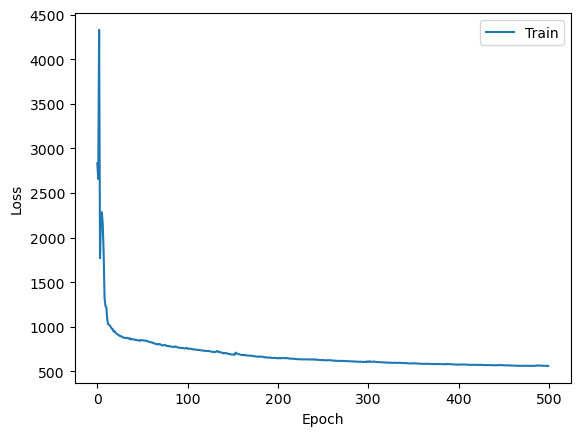

In [55]:
plt.plot(history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

### Use CVAE model to predict train images

In [56]:
z_mean, z_log_var, z =  vae.encoder.predict(data_flow[0][0])
reconstruction = vae.decoder.predict(z)

4/4 [==============================] - 0s 7ms/step


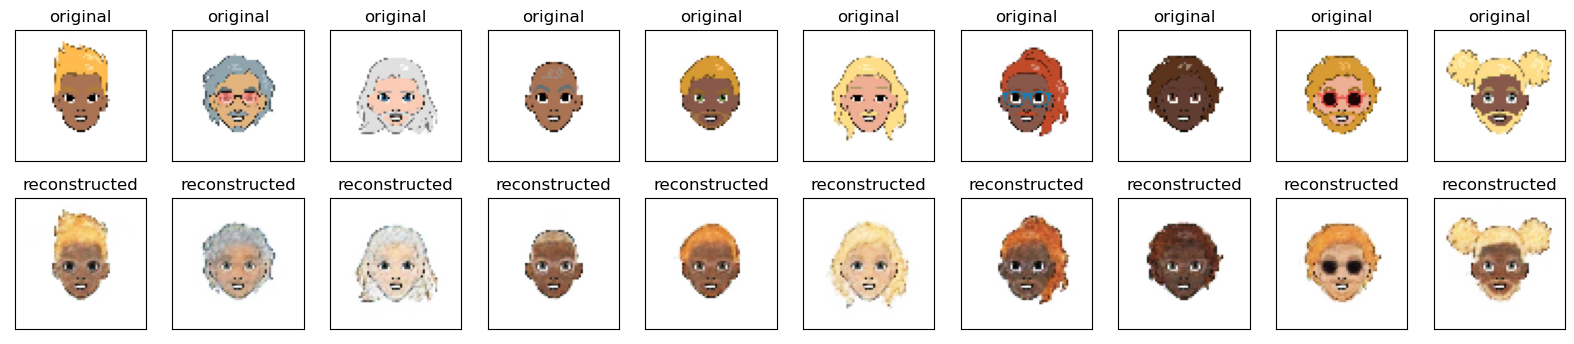

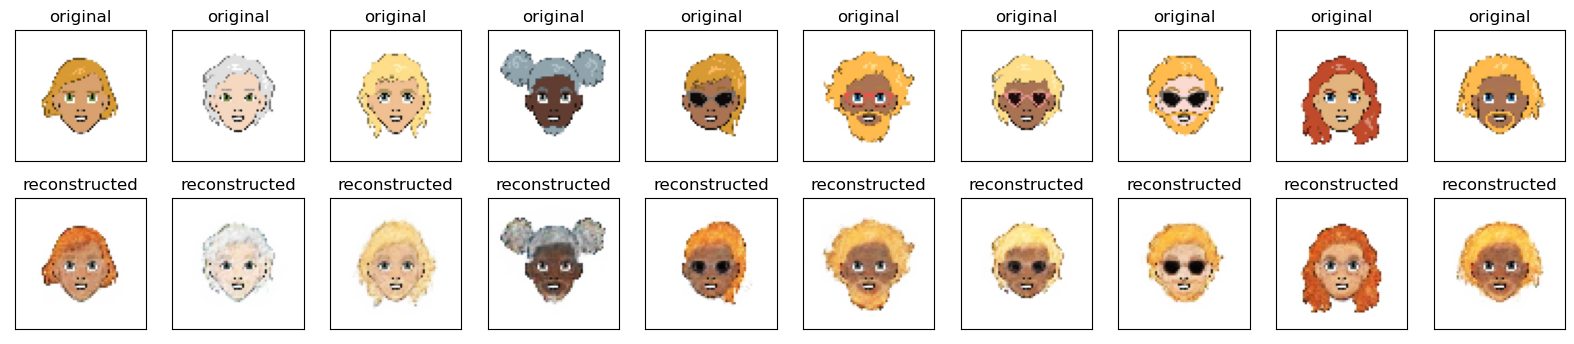

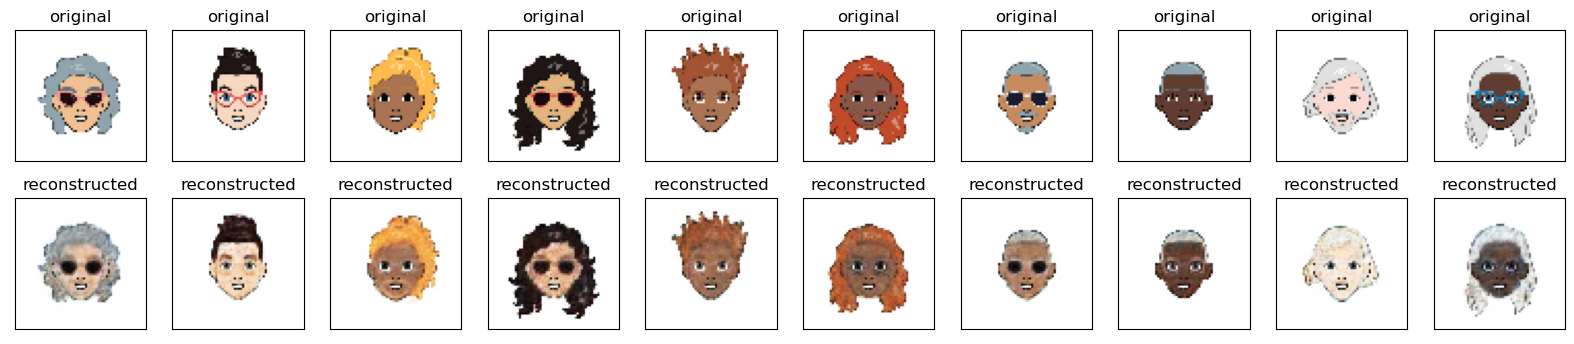

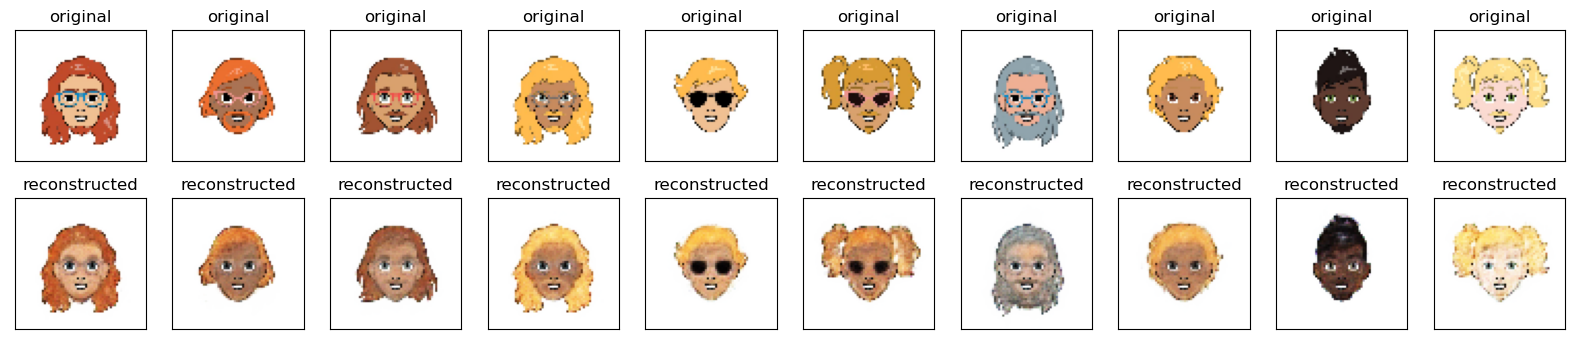

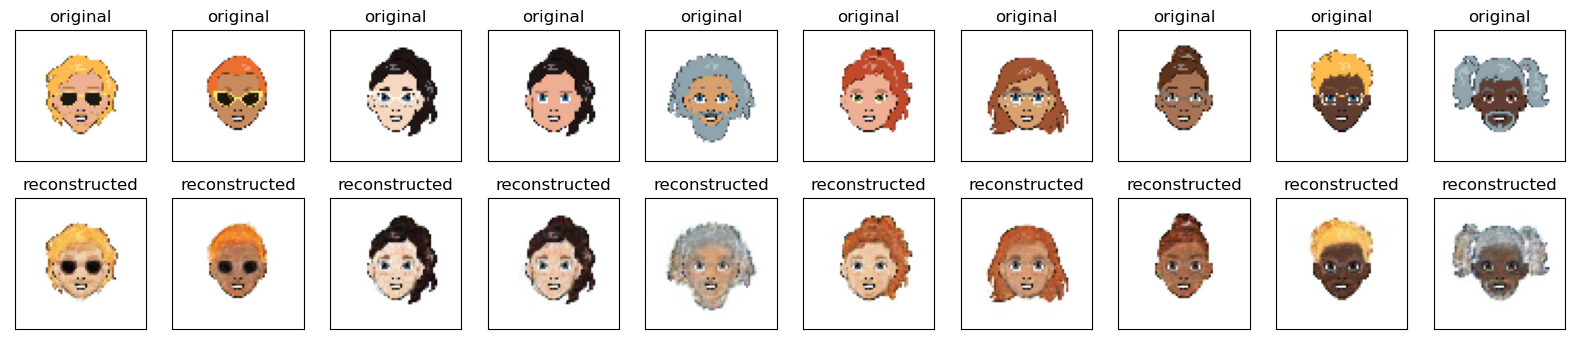

In [57]:
n = 10

for j in range(5):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(data_flow[0][0][i+j*10, :, :, :])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstruction[i+j*10, :, :,:])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

### Use CVAE model to predict test images

In [58]:
z_mean, z_log_var, z =  vae.encoder.predict(data_flow[1][0])
reconstruction = vae.decoder.predict(z)

4/4 [==============================] - 0s 8ms/step


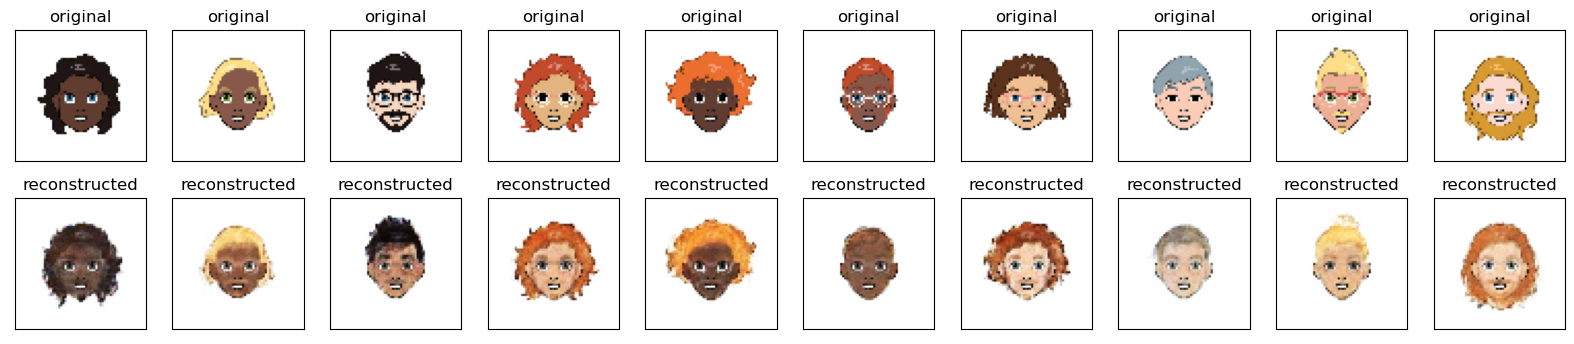

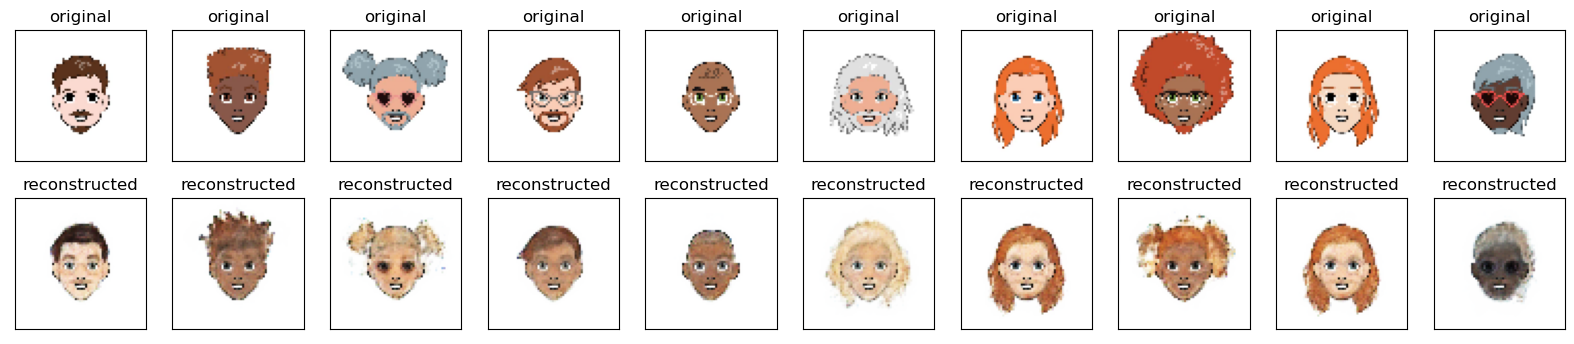

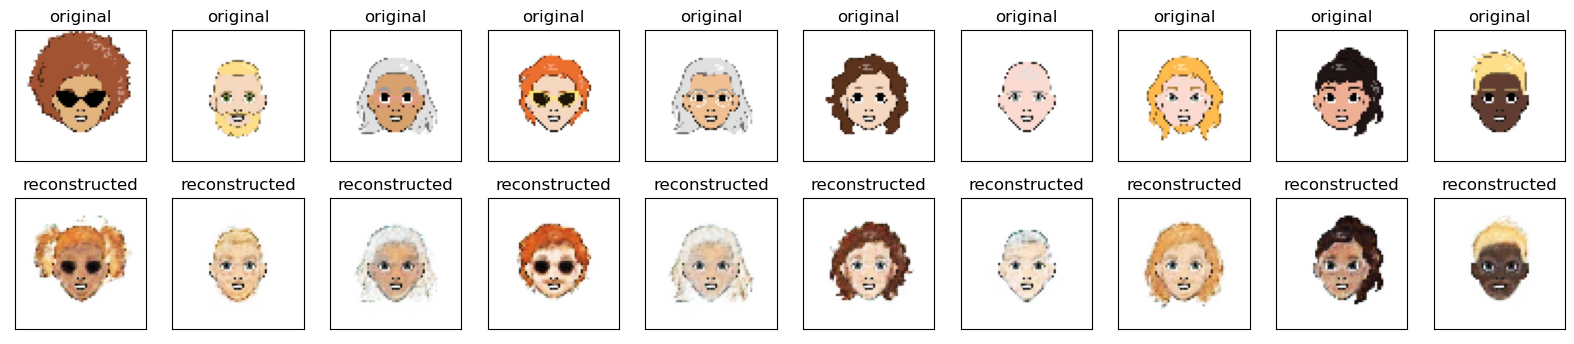

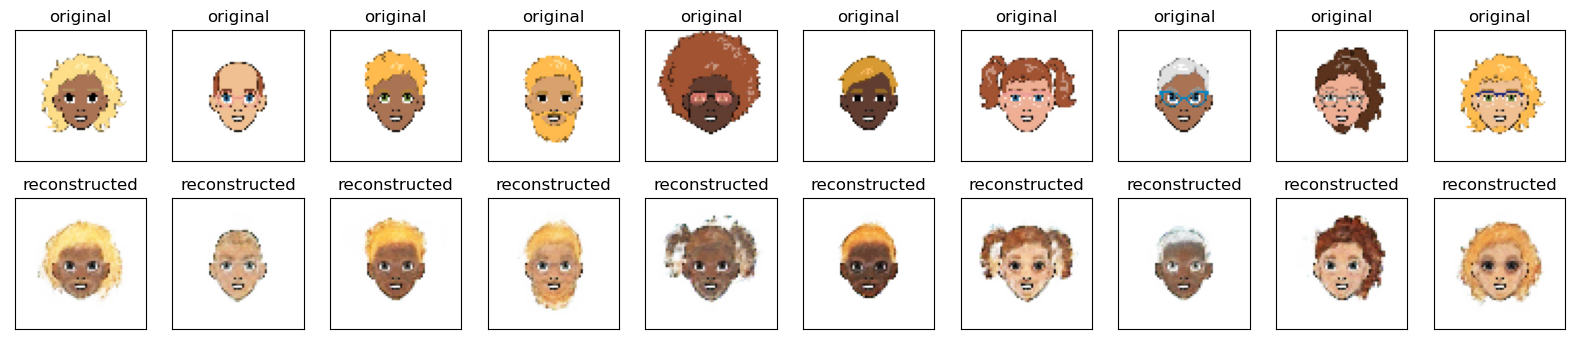

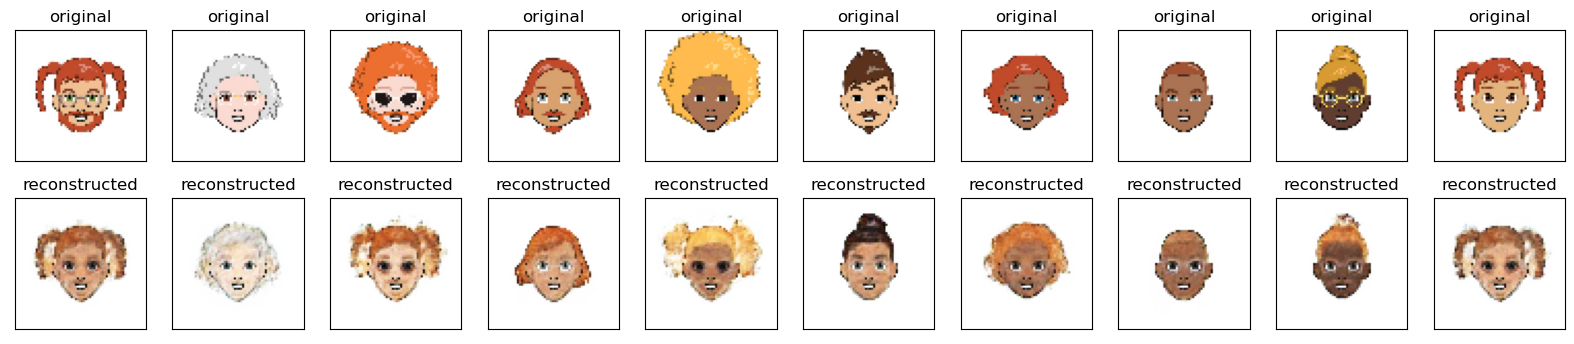

In [59]:
n = 10

for j in range(5):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(data_flow[1][0][i+j*10, :, :, :])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstruction[i+j*10, :, :,:])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

### Interpolating two images

1/1 [==============================] - 0s 25ms/step


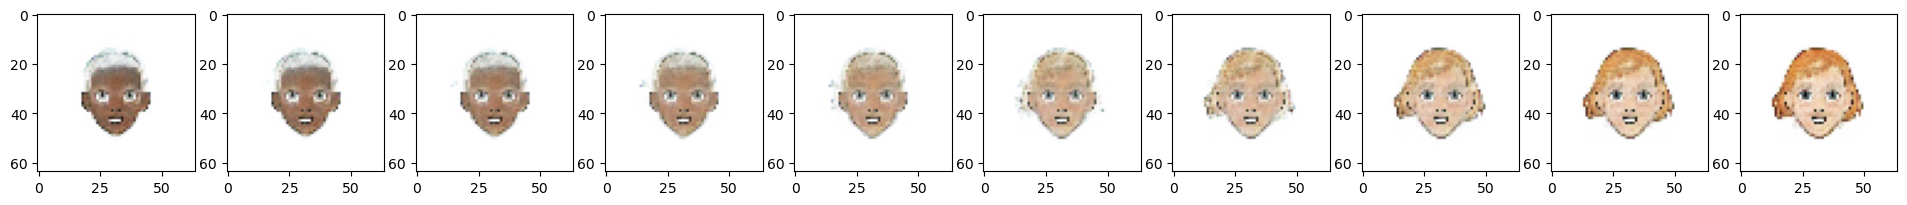

In [64]:
face_one_latent = z[np.random.randint(0, 64)]
face_two_latent = z[np.random.randint(64, 128)]

f = plt.figure(figsize=(24,16))

alphaValues = np.linspace(0,1,10)
plot_index = 1

for alpha in alphaValues:
    vec = face_one_latent*(1-alpha) + face_two_latent*alpha
    vec = np.reshape(vec, (1, 128))
    decoded = vae.decoder.predict(vec)
    f.add_subplot(1,10,plot_index)
    plt.imshow(np.reshape(decoded,(64,64,3)))
    plot_index +=1
    

### Checking out what sort of output we get from noise sampled from normal distribution

1/1 [==============================] - 0s 50ms/step


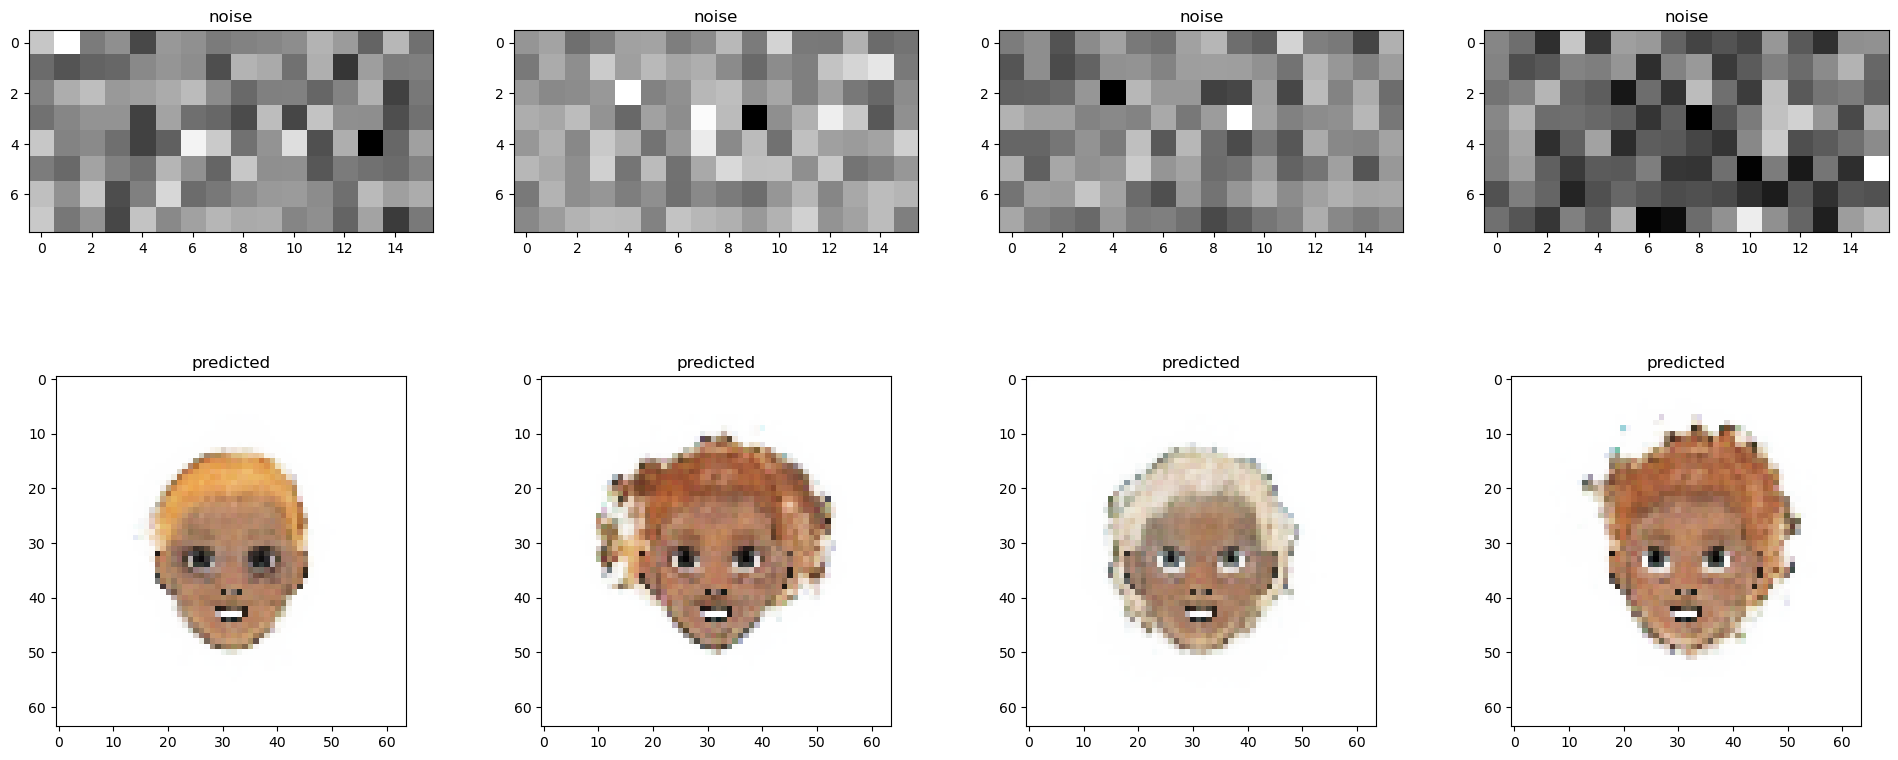

In [61]:

noise = np.random.normal(size=(4,128))
f = plt.figure(figsize=(24,10))

for i in range(4):
    f.add_subplot(2,4,i+5)
    plt.title("predicted")
    pred = vae.decoder.predict(noise)
    plt.imshow(np.reshape(pred[i],(64,64,3)))
    
    f.add_subplot(2,4,i+1)
    plt.title("noise")
    plt.imshow(np.reshape(noise[i], (8,16)))

plt.show()